In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from  av.io import read
import pandas as pd
import datetime
import tensorflow as tf
#tf.enable_eager_execution()

from glob import glob
from sklearn.preprocessing import normalize
from tensorflow import keras

import string
import os



In [13]:
use_rotation_sensor = False
use_accelerometer_sensor = True
use_gyroscope_sensor = True
use_magnetic_sensor = False
sensor_inputs = 0
normalize_vector = np.array([])

if use_rotation_sensor:
    sensor_inputs += 5
    normalize_vector = np.append(normalize_vector, [1,1,1,1,1], axis=0)

if use_accelerometer_sensor:
    sensor_inputs += 3
    normalize_vector = np.append(normalize_vector, [15,15,15], axis=0)
    
if use_gyroscope_sensor:
    sensor_inputs += 3
    normalize_vector = np.append(normalize_vector, [3,3,3], axis=0)

if use_magnetic_sensor:
    sensor_inputs += 3
    normalize_vector = np.append(normalize_vector, [40,40,40], axis=0)


cut_shape = (100, sensor_inputs)
gestures = {0: 'noise', 1: 'Left', 2: 'Right'}
gestures_reverse = {"left" : 1, "noise" : 0, "right" : 2}

data_folder = "data/"
patterns = {"left" : "swipe_left_20*.mkv", "right" : "swipe_right_20*.mkv", "noise" : "*noise*.mkv"} 
data_split_folder = "data_singled/"

In [14]:
def read_file(filename, lable=None):
    data, meta = read(" ".join(["a:" + str(i) for i in range(4)]), filename, 50)
    datapairs = list(zip(data, meta))
    
    df = pd.DataFrame()
    names = []
    col_name_tpls = []
    for sensor_data, stream_object in datapairs:
        meta_dict = stream_object.metadata
        # print(meta_dict)
        name = meta_dict["NAME"]
        names.append(name)
        n_cols = len(sensor_data)
        col_names = []
        for i in range(n_cols):
            col_name = name + "_" + str(i)
            col_names.append(col_name)
            df[col_name] = pd.Series(sensor_data.T[:,i])
        col_name_tpls.append(col_names)
    df.index = pd.TimedeltaIndex(freq="20ms", start=0.0, periods=len(df))
    return df, col_name_tpls

def trim_data(data_frame, start=0.0, end=None):
    if end:
        df = data_frame[pd.Timedelta(10**9 * start):pd.Timedelta(10**9 * end)]
    else:
        df = data_frame[pd.Timedelta(10**9 * start):]
    return df

def cut_data(data_frame, cuts):
    df_cut_list = np.ndarray(shape=(len(cuts),) + cut_shape)
    for i, cut in enumerate(cuts):
        df_i = data_frame[pd.Timedelta(10**9 * cut[0]):pd.Timedelta(10**9 * cut[1])]
        start_chanel = 0
        if len(df_i) < 100:
            continue
        if not use_rotation_sensor:
            start_chanel = 5
        df_cut_list[i, : , :] = df_i.iloc[0: 100, start_chanel:8]

    return df_cut_list


def find_peaks(df, sensor, start=0.0, end=None, sel_method="right"):
    peaks = []
    if end:
        df = df[pd.Timedelta(10**9 * start):pd.Timedelta(10**9 * end)]
    else:
        df = df[pd.Timedelta(10**9 * start):]

    for i in df.index:
        value = df[sensor][i]
        if sel_method == "right":
            cond = value > 7.5
        elif sel_method == "left":
            cond = value < -1
        if cond:
            new = True
            for peak in peaks:
                if i - pd.Timedelta(10**9) < peak + pd.Timedelta(10**9):
                    new = False
                    break
            if new:
                peaks.append(i)
    cuts = []
    for peak in peaks:
        t = peak.value / 10 ** 9
        cuts.append((t-1, t+1))
    return cuts 

def normalize_cuts(cuts):
    for i in range(len(cuts)):
        cuts[i, : , :] = cuts[i]/normalize_vector
    return cuts
  

def plot_dataframe(df, col_name_tpls):
    for col_name_tpl in col_name_tpls:
        for col_name in col_name_tpl:
            fig = df[col_name].plot()
            fig.set_title(col_name)
            plt.show()

def plot_cuts(cuts, sensor=None):
    if sensor is None:
        for i, cut in enumerate(cuts):
            plt.plot(cut, label=str(i))
            plt.legend()
            plt.show()
        return
    for cut in cuts:
        cut = cut[sensor]
        cut = cut.values.reshape(-1,1)
        print(cut.shape)
        normed_matrix = normalize(cut, axis=0, norm='l1')
        plt.plot(normed_matrix)
        
        plt.show()

In [29]:
def read_file(filename, lable=None):
    data, meta = read(" ".join(["a:" + str(i) for i in range(4)]), filename, 50)
    datapairs = list(zip(data, meta))
    
    df = pd.DataFrame()
    names = []
    col_name_tpls = []
    for sensor_data, stream_object in datapairs:
        meta_dict = stream_object.metadata
        # print(meta_dict)
        name = meta_dict["NAME"]
        names.append(name)
        n_cols = len(sensor_data)
        col_names = []
        for i in range(n_cols):
            col_name = name + "_" + str(i)
            col_names.append(col_name)
            df[col_name] = pd.Series(sensor_data.T[:,i])
        col_name_tpls.append(col_names)
    df.index = pd.TimedeltaIndex(freq="20ms", start=0.0, periods=len(df))
    return df, col_name_tpls

def trim_data(data_frame, start=0.0, end=None):
    if end:
        df = data_frame[pd.Timedelta(10**9 * start):pd.Timedelta(10**9 * end)]
    else:
        df = data_frame[pd.Timedelta(10**9 * start):]
    return df

def cut_data(data_frame, cuts):
    df_cut_list = np.ndarray(shape=(len(cuts),) + cut_shape)
    for i, cut in enumerate(cuts):
        df_i = data_frame[pd.Timedelta(10**9 * cut[0]):pd.Timedelta(10**9 * cut[1])]
        prev_sensor_channels = 0
        if len(df_i) < 100:
            continue
        if use_rotation_sensor:
            df_cut_list[i, : , 0:5] = df_i.iloc[0: 100, 0:5]
            prev_sensor_channels += 5
        if use_accelerometer_sensor:
            df_cut_list[i, : , prev_sensor_channels:prev_sensor_channels+3] = df_i.iloc[0: 100, 5:8]
            prev_sensor_channels += 3
        if use_gyroscope_sensor:
            df_cut_list[i, : , prev_sensor_channels:prev_sensor_channels+3] = df_i.iloc[0: 100, 8:11]
            prev_sensor_channels += 3
        if use_magnetic_sensor:
            df_cut_list[i, : , prev_sensor_channels:prev_sensor_channels+3] = df_i.iloc[0: 100, 11:14]
            prev_sensor_channels += 3
    return df_cut_list


def find_peaks(df, sensor, start=0.0, end=None):
    peaks = []
    if end:
        df = df[pd.Timedelta(10**9 * start):pd.Timedelta(10**9 * end)]
    else:
        df = df[pd.Timedelta(10**9 * start):]

    for i in df.index:
        value = df[sensor][i]
        if abs(value) > 7:
            new = True
            for peak in peaks:
                if i - pd.Timedelta(10**9) < peak + pd.Timedelta(10**9):
                    new = False
                    break
            if new:
                peaks.append(i)
    cuts = []
    for peak in peaks:
        t = peak.value / 10 ** 9
        cuts.append((t-1, t+1))
    return cuts 

def normalize_cuts(cuts):
    for i in range(len(cuts)):
        cuts[i, : , :] = cuts[i]/normalize_vector
    return cuts
  

def plot_dataframe(df, col_name_tpls):
    for col_name_tpl in col_name_tpls:
        for col_name in col_name_tpl:
            fig = df[col_name].plot()
            fig.set_title(col_name)
            plt.show()

def plot_cuts(cuts, sensor=None):
    if sensor is None:
        for i, cut in enumerate(cuts):
            plt.plot(cut, label=str(i))
            plt.legend()
            plt.show()
        return
    for cut in cuts:
        cut = cut[sensor]
        cut = cut.values.reshape(-1,1)
        print(cut.shape)
        normed_matrix = normalize(cut, axis=0, norm='l1')
        plt.plot(normed_matrix)
        plt.show()

In [30]:
for gesture in patterns.keys():
    gesture_file_list = glob(data_folder + patterns[gesture])
    print(gesture_file_list)

['data/swipe_left_20_0.mkv']
['data/swipe_right_20_0.mkv', 'data/swipe_right_20_1.mkv']
['data/noise_0.mkv', 'data/noise_1.mkv']


In [31]:
def export_data(force_overwrite=False, do_result_plots=False):
    """export all the data!!
    force_overwrite: overwrite already exported data
    do_result_plots: show plots of resulting gesture cuts again.
    """
    for gesture in patterns.keys():
        gesture_file_list = glob(data_folder + patterns[gesture])
        k = 0
        for filename in gesture_file_list:
            assert filename.count("/") == 1
            rev_file = filename[::-1]

            ind = len(filename) - rev_file.index("_")
            gesture_name = filename[filename.index("/")+1:ind-1]
            gesutre_name_copy = gesture_name
            while gesture_name[-1].lower() not in string.ascii_lowercase:
                gesture_name = gesture_name[:-1]
            try:
                num_cuts = int(gesutre_name_copy[len(gesture_name) - len(gesutre_name_copy) +1:])
            except:
                print(f"WARNING, in FILE DOES NOT SET AMOUNT OF CUTS: {filename}")
                num_cuts = False
            number = filename[ind:filename.index(".")]
            if os.path.isfile(data_split_folder + gesture_name + "_" + number + "_000.csv") and not force_overwrite:
                print(f"File {filename} was already exported, force overwrite if needed.")
                continue
            df, col_name_tpls = read_file(filename)
            df["Cywee Accelerometer Sensor_2"].plot()
            plt.show()
            start = int(input("start?"))
            try:
                end = int(input("end?"))
            except:
                end = False
            if end:
                trimed_df = trim_data(df, start, end)
            else:
                trimed_df = trim_data(df, start)
            peaks = find_peaks(trimed_df, "Cywee Accelerometer Sensor_2")
            print(len(peaks), ":", peaks)
            cuts = normalize_cuts(cut_data(trimed_df, peaks))
            print("Found cuts:", len(cuts))
            plot_cuts(cuts)
            r = eval(input("remove cuts?? (divide by \',\') "))
            assert type(r) == list
            l_cuts = []   # list to keep cuts
            for i, cut in enumerate(cuts):
                if i not in r:
                    l_cuts.append(cut)
            #cuts = np.asarray(l)
            if num_cuts:
                if len(l_cuts) != num_cuts:
                    print(f"WARNING: expected {num_cuts} but got {len(l_cuts)}")
                else:
                    print("correct number of cuts reached")
            for n, cut in enumerate(l_cuts):
                n_str = str(n)
                while len(n_str) < 3:
                    n_str = "0" + n_str
                np.savetxt(data_split_folder + gesture_name + "_" + number + "_" + n_str + ".csv", cut, delimiter=",")
            if do_result_plots:
                plot_cuts(l_cuts)

In [61]:
def load_data(patterns=patterns):
    data_dict = {pattern : [] for pattern in patterns}
    for gesture in patterns:
        gesture_file_list = glob(data_split_folder + "/*" + gesture +"*")
        for i, gesture_file in enumerate(gesture_file_list):
            data = np.loadtxt(gesture_file, delimiter=",")
            data_dict[gesture].append(data)
    
    #combine into X and y
    
    X = []
    y = []
    for gesture in patterns:
        X.extend(data_dict[gesture])
        y.extend([gestures_reverse[gesture]] * len(data_dict[gesture]))
    
    
    return np.asarray(X), y

File data/swipe_left_20_0.mkv was already exported, force overwrite if needed.
File data/swipe_left_20_1.mkv was already exported, force overwrite if needed.
File data/swipe_left_20_2.mkv was already exported, force overwrite if needed.
File data/swipe_left_20_3.mkv was already exported, force overwrite if needed.


/home/gende/repos/PyAV/venvs/Linux.4.4.0-17134-Microsoft.cpython3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Creating a TimedeltaIndex by passing range endpoints is deprecated.  Use `pandas.timedelta_range` instead.


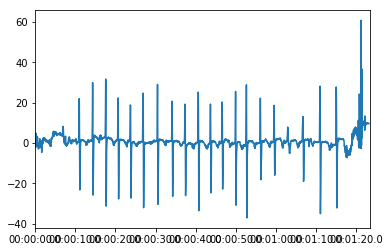

start?10
end?80
22 : [(9.9, 11.9), (13.24, 15.24), (16.5, 18.5), (19.58, 21.58), (22.66, 24.66), (25.8, 27.8), (29.42, 31.42), (33.08, 35.08), (36.28, 38.28), (39.6, 41.6), (42.62, 44.62), (45.54, 47.54), (48.9, 50.9), (51.58, 53.58), (55.06, 57.06), (58.5, 60.5), (61.96, 63.96), (65.64, 67.64), (69.92, 71.92), (74.0, 76.0), (76.76, 78.76), (78.84, 80.84)]
Found cuts: 22


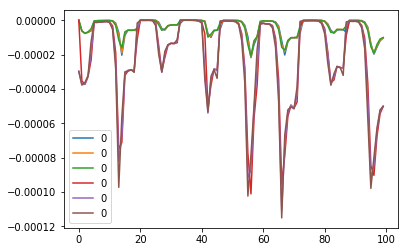

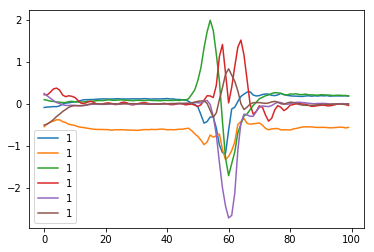

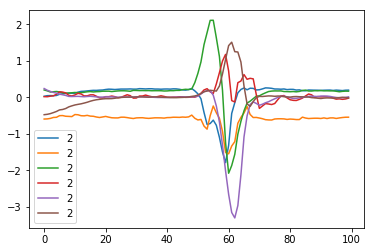

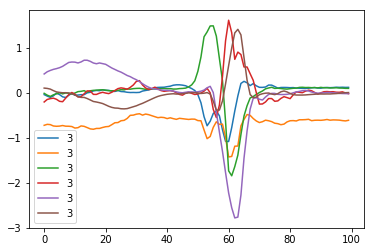

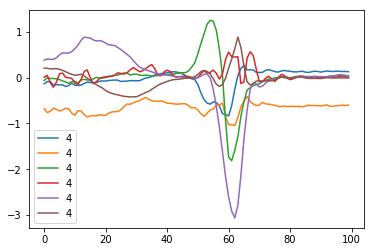

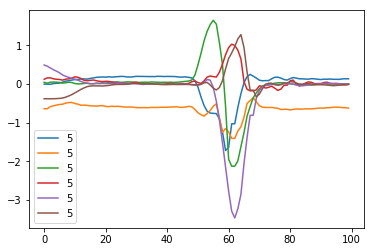

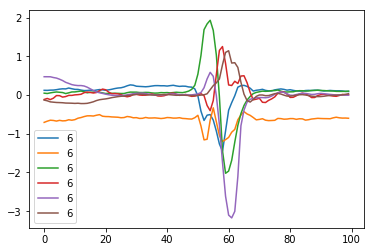

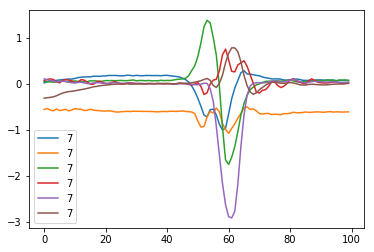

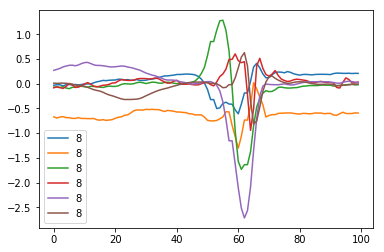

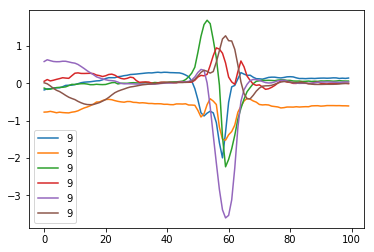

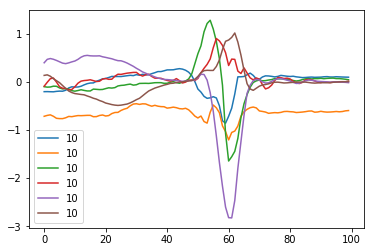

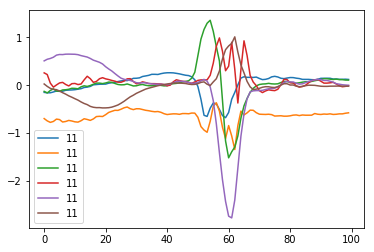

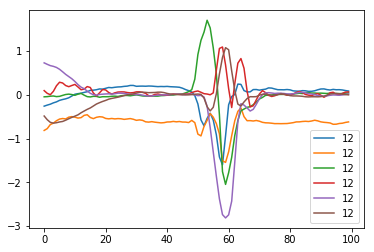

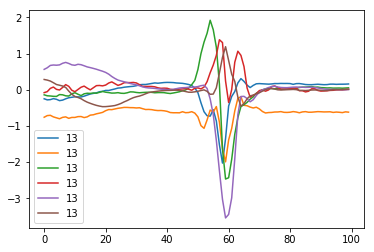

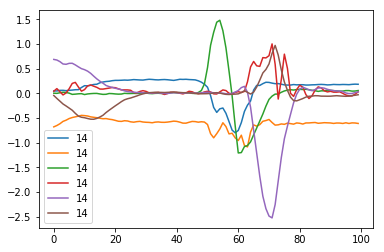

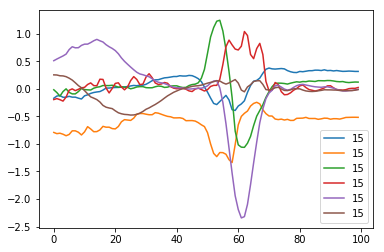

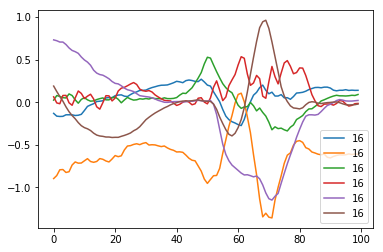

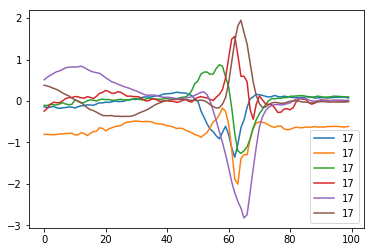

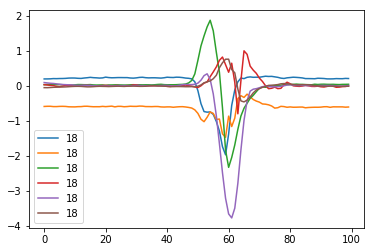

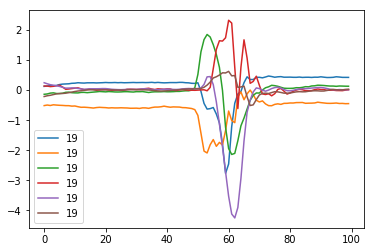

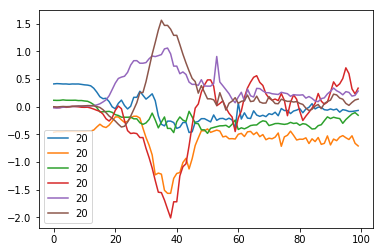

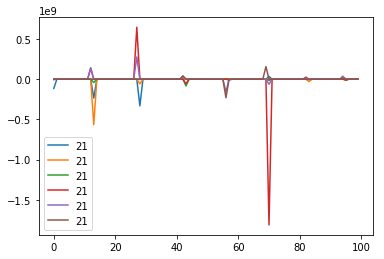

remove cuts?? (divide by ',') [0,20,21]
File data/swipe_right_20_0.mkv was already exported, force overwrite if needed.
File data/swipe_right_20_1.mkv was already exported, force overwrite if needed.
File data/swipe_right_20_2.mkv was already exported, force overwrite if needed.
File data/swipe_right_20_3.mkv was already exported, force overwrite if needed.
File data/swipe_right_20_4.mkv was already exported, force overwrite if needed.
WARNING, in FILE DOES NOT SET AMOUNT OF CUTS: data/noise_0.mkv
File data/noise_0.mkv was already exported, force overwrite if needed.
WARNING, in FILE DOES NOT SET AMOUNT OF CUTS: data/noise_1.mkv
File data/noise_1.mkv was already exported, force overwrite if needed.


In [70]:
export_data()

In [71]:
X, y = load_data()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


In [72]:
def  learn_clisifyer(data, lables):
    print(data.shape)
    model = keras.Sequential([
        #keras.layers.Flatten(),
        keras.layers.Flatten(input_shape=cut_shape),
        keras.layers.Dense(100 * len(normalize_vector), activation=tf.nn.relu),
        keras.layers.Dense(3, activation=tf.nn.softmax)
    ])
    model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    model.fit(data, lables, epochs=50)
    test_loss, test_acc = model.evaluate(data, lables)

    print('Test accuracy:', test_acc)
    
    return model

    



In [78]:
tf_model = learn_clisifyer(X_train, y_train)

(193, 100, 6)
Epoch 1/50
193/193 [==============================] - 0s 860us/sample - loss: 0.4901 - acc: 0.7979
Epoch 2/50
193/193 [==============================] - 0s 271us/sample - loss: 0.0823 - acc: 0.9793
Epoch 3/50
193/193 [==============================] - 0s 247us/sample - loss: 0.0225 - acc: 1.0000
Epoch 4/50
193/193 [==============================] - 0s 303us/sample - loss: 0.0097 - acc: 1.0000
Epoch 5/50
193/193 [==============================] - 0s 294us/sample - loss: 0.0047 - acc: 1.0000
Epoch 6/50
193/193 [==============================] - 0s 266us/sample - loss: 0.0030 - acc: 1.0000
Epoch 7/50
193/193 [==============================] - 0s 287us/sample - loss: 0.0023 - acc: 1.0000
Epoch 8/50
193/193 [==============================] - 0s 255us/sample - loss: 0.0018 - acc: 1.0000
Epoch 9/50
193/193 [==============================] - 0s 266us/sample - loss: 0.0016 - acc: 1.0000
Epoch 10/50
193/193 [==============================] - 0s 270us/sample - loss: 0.0014 - acc: 1.

In [79]:
tf_model.evaluate(X_test, y_test)

65/65 [==============================] - 0s 143us/sample - loss: 0.1669 - acc: 0.9385


[0.16693335129644205, 0.93846154]

In [94]:
import sklearn.svm
clf = sklearn.svm.SVC(gamma=1.0, decision_function_shape='ovo', probability=True)
clf.fit(get_features(X_train), y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=1.0, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [98]:
preds = clf.predict(get_features(X_test))

In [101]:
c = 0
for i in range(len(preds)):
    c += int(preds[i] == y_test[i])
print(f" SVM Accuracy: {c / len(preds)}")

 SVM Accuracy: 0.8307692307692308


In [80]:
def prepare_learn_set(data_frame, previous_learned_data=None):
    peaks = find_peaks(data_frame, "Cywee Accelerometer Sensor_2")
    cuts = cut_data(data_frame, peaks)
    #cuts_full = [cut for cut in cuts if len(cut) == 100]
    learn_data = normalize_cuts(cuts) # Normalize
    print("DataShape:", learn_data.shape)
    
    if previous_learned_data is not None:
        learn_data = np.append(learn_data, previous_learned_data, axis=0)
    return learn_data
    
    

# Use Tensorflow to classify gestures

## Learn model


In [13]:
df, col_name_tpls = read_file("swipe_right_10_new.mkv")
trimed_df = trim_data(df, 52, 90)
learn_data_r = prepare_learn_set(trimed_df)

df, col_name_tpls = read_file("swipe_left_10.mkv")
trimed_df = trim_data(df, 10, 57)
learn_data_l = prepare_learn_set(trimed_df)

df, col_name_tpls = read_file("data/swipe_left_20_0.mkv")
trimed_df = trim_data(df, 15, 90)
learn_data_l = prepare_learn_set(trimed_df, learn_data_l)

df, col_name_tpls = read_file("random_noise.mkv")
trimed_df = trim_data(df, 0)
cuts = cut_data(trimed_df, [(i * 2, i*2+2) for i in range(50)])
learn_data_noise = normalize_cuts(cuts)
print("Noiseshape:", learn_data_noise.shape)
print("Learn L shape:", learn_data_l.shape)

learn_data = np.append(learn_data_noise, learn_data_l, axis=0)
learn_data = np.append(learn_data, learn_data_r, axis=0)

lables = [0]*len(learn_data_noise) + [1]*len(learn_data_l) + [2]*len(learn_data_r)

print("Learn data has shape: {}".format(learn_data.shape))
model = learn_clisifyer(learn_data, lables)


/home/gende/repos/PyAV/venvs/Linux.4.4.0-17134-Microsoft.cpython3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Creating a TimedeltaIndex by passing range endpoints is deprecated.  Use `pandas.timedelta_range` instead.


DataShape: (9, 100, 6)
DataShape: (9, 100, 6)
DataShape: (18, 100, 6)
Noiseshape: (50, 100, 6)
Learn L shape: (27, 100, 6)
Learn data has shape: (86, 100, 6)
(86, 100, 6)
Instructions for updating:
Colocations handled automatically by placer.
Epoch 1/50
86/86 [==============================] - 0s 2ms/sample - loss: 0.8017 - acc: 0.6047
Epoch 2/50
86/86 [==============================] - 0s 348us/sample - loss: 0.2594 - acc: 0.9070
Epoch 3/50
86/86 [==============================] - 0s 429us/sample - loss: 0.1072 - acc: 0.9767
Epoch 4/50
86/86 [==============================] - 0s 405us/sample - loss: 0.0693 - acc: 0.9767
Epoch 5/50
86/86 [==============================] - 0s 496us/sample - loss: 0.0463 - acc: 1.0000
Epoch 6/50
86/86 [==============================] - 0s 448us/sample - loss: 0.0275 - acc: 1.0000
Epoch 7/50
86/86 [==============================] - 0s 372us/sample - loss: 0.0184 - acc: 1.0000
Epoch 8/50
86/86 [==============================] - 0s 340us/sample - loss: 0.01

# Test learned model
Test data has gestures:
Left, Left, Left, Left, Right, Right, Right, Left, Left

In [14]:
df, col_name_tpls = read_file("swipe_test_both.mkv")
trimed_df = trim_data(df, 10, 55)
test_data = prepare_learn_set(trimed_df) 
test_lables = [1, 1, 1, 1, 2, 2, 2, 1, 1]

predictions = model.predict(test_data)
print('Predicted:')
for i, p in enumerate(predictions):
    print('{}: {} should be {} -> {}'.format(i, gestures[np.argmax(p)], 
                                         gestures[test_lables[i]], np.argmax(p) == test_lables[i]))

print('\nTest if noise will be predicted as noise')
df, col_name_tpls = read_file("data/noise_0.mkv")
trimed_df = trim_data(df, 16, 88)
learn_data_noise = prepare_learn_set(trimed_df)
noise_predictions = model.predict(learn_data_noise)
for p in noise_predictions:
    print(gestures[np.argmax(p)])

/home/gende/repos/PyAV/venvs/Linux.4.4.0-17134-Microsoft.cpython3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Creating a TimedeltaIndex by passing range endpoints is deprecated.  Use `pandas.timedelta_range` instead.


DataShape: (9, 100, 6)
Predicted:
0: Left should be Left -> True
1: Left should be Left -> True
2: Left should be Left -> True
3: Left should be Left -> True
4: Right should be Right -> True
5: Right should be Right -> True
6: Right should be Right -> True
7: Left should be Left -> True
8: Left should be Left -> True

Test if noise will be predicted as noise
DataShape: (18, 100, 6)
Left
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
Left
Left
noise
Left
noise
noise


In [15]:
for p in predictions:
    print(max(p))

0.99992967
0.99981886
0.9998678
0.9998754
0.99618274
0.99850696
0.9956299
0.9998228
0.9998702


In [16]:
for p in noise_predictions:
    if np.argmax(p) != 0:
        print("classified as left or right with confidence {:.2f}%".format(max(p)*100))
    else:
        print("classified as noise,", max(p))

classified as left or right with confidence 74.49%
classified as noise, 0.9939711
classified as noise, 0.8444485
classified as noise, 0.8949499
classified as noise, 0.8388221
classified as noise, 0.687393
classified as noise, 0.603997
classified as noise, 0.62971205
classified as noise, 0.6267841
classified as noise, 0.633206
classified as noise, 0.60197926
classified as noise, 0.55984926
classified as left or right with confidence 67.49%
classified as left or right with confidence 98.45%
classified as noise, 0.6847603
classified as left or right with confidence 83.34%
classified as noise, 0.7621852
classified as noise, 0.9864188


# Train SVM:

## Define features

In [86]:
import sklearn.svm

def get_features(tf_learn_data, mode="features"):
    out_data = []
    for learn_data in tf_learn_data:
        feature_vec = []
        for split in range(15,101, 15):
            cur_split = learn_data[split-15:split+10]
            for i in range(cur_split.shape[1]):
                sensor_data  = cur_split[:,i]
                feature_vec.append(0 if np.isnan(sensor_data.mean()) else sensor_data.mean())
                feature_vec.append(0 if np.isnan(sensor_data.max()) else sensor_data.max())
                feature_vec.append(0 if np.isnan(sensor_data.min()) else sensor_data.min())
                #feature_vec.append(np.median(sensor_data))
        if mode == "features":
            #print(feature_vec)
            out_data.append(feature_vec)
        elif mode == "raw":
            out_data.append(learn_data.flatten())
    return np.array(out_data)

## Train with features


In [18]:
#X_train = get_features(learn_data)
y = lables
X,y = load_data()
X_train = get_features(X, "features")
#print(pd.DataFrame(X_train)[594])

x_t_df = pd.DataFrame(X_train)

X_test = test_data
y_test = test_lables


clf = sklearn.svm.SVC(gamma=1.0, decision_function_shape='ovo', probability=True)
clf.fit(X_train, y) 
predictions = clf.predict(get_features(test_data))

print('Predicted:')
for i, p in enumerate(predictions):
    print('{}: {} should be {} -> {}'.format(i, gestures[p], 
                                         gestures[y_test[i]], p == y_test[i]))

    
print(clf.predict(get_features(learn_data_noise)))

Predicted:
0: Left should be Left -> True
1: Left should be Left -> True
2: Left should be Left -> True
3: Left should be Left -> True
4: Right should be Right -> True
5: Right should be Right -> True
6: Right should be Right -> True
7: Left should be Left -> True
8: Left should be Left -> True
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


## Test on test data

 - tensorflow model
 - svm classifies

In [19]:
def predict_from_file(filename, mode="tensorflow", print_res=False):
    """
    pipeline including reading the file, running a classifier
    and outputting the results
    """
    df, col_name_tpls = read_file(filename)
    length = len(df) / 50
    trimed_df = trim_data(df, 5, length-1)
    test_data = prepare_learn_set(trimed_df)
    if mode == "tensorflow":
        res = model.predict(test_data)
    elif mode == "svm":
        res = clf.predict_proba(get_features(test_data))
    preds_and_confs = [(np.argmax(p), p[np.argmax(p)]) for p in res]
    if print_res:
        print([gestures[p[0]] for p in preds_and_confs])
    return np.array(preds_and_confs)

In [20]:
predict_from_file("swipe_test_both.mkv", "svm")


/home/gende/repos/PyAV/venvs/Linux.4.4.0-17134-Microsoft.cpython3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Creating a TimedeltaIndex by passing range endpoints is deprecated.  Use `pandas.timedelta_range` instead.


DataShape: (13, 100, 6)


array([[2.        , 0.9202742 ],
       [1.        , 0.93373862],
       [1.        , 0.9743614 ],
       [1.        , 0.93775698],
       [1.        , 0.92583407],
       [2.        , 0.93675528],
       [2.        , 0.9404898 ],
       [2.        , 0.94796262],
       [1.        , 0.97534911],
       [1.        , 0.97570821],
       [2.        , 0.92043766],
       [2.        , 0.9204381 ],
       [2.        , 0.9204381 ]])

In [21]:
predict_from_file("swipe_test_both.mkv", "tensorflow")

/home/gende/repos/PyAV/venvs/Linux.4.4.0-17134-Microsoft.cpython3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Creating a TimedeltaIndex by passing range endpoints is deprecated.  Use `pandas.timedelta_range` instead.


DataShape: (13, 100, 6)


array([[1.        , 0.97551984],
       [1.        , 0.99992967],
       [1.        , 0.99981886],
       [1.        , 0.9998678 ],
       [1.        , 0.99987543],
       [2.        , 0.99618274],
       [2.        , 0.99850696],
       [2.        , 0.99562991],
       [1.        , 0.9998228 ],
       [1.        , 0.99987018],
       [1.        , 0.98267132],
       [0.        , 0.96987027],
       [1.        , 1.        ]])

In [22]:
predict_from_file("data/swipe_right_20_1.mkv", "tensorflow")

/home/gende/repos/PyAV/venvs/Linux.4.4.0-17134-Microsoft.cpython3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Creating a TimedeltaIndex by passing range endpoints is deprecated.  Use `pandas.timedelta_range` instead.


DataShape: (28, 100, 6)


array([[1.        , 0.96316713],
       [2.        , 0.95352268],
       [0.        , 0.99958318],
       [0.        , 0.63238692],
       [0.        , 0.73686892],
       [2.        , 0.97479975],
       [2.        , 0.99740428],
       [2.        , 0.99943191],
       [2.        , 0.99715853],
       [2.        , 0.99835384],
       [2.        , 0.99931419],
       [2.        , 0.99916613],
       [2.        , 0.99898607],
       [2.        , 0.99835348],
       [2.        , 0.99461693],
       [2.        , 0.99922252],
       [2.        , 0.99883038],
       [2.        , 0.99957865],
       [2.        , 0.99668711],
       [2.        , 0.9998005 ],
       [2.        , 0.99782771],
       [2.        , 0.99991298],
       [2.        , 0.99982625],
       [2.        , 0.99946731],
       [2.        , 0.9996556 ],
       [1.        , 0.92151487],
       [0.        , 0.98140782],
       [0.        , 0.99991107]])

In [26]:
def live_demo(filename="data/live_demo.mkv"):
    import warnings
    warnings.filterwarnings("ignore")
    res_tf = predict_from_file(filename, "tensorflow")
    res_svm = predict_from_file(filename, "svm")
    print(res_svm)
    
    res_tf = [gestures[p[0]] for p in res_tf if p[1] > 0.95]
    res_svm = [gestures[p[0]] for p in res_svm if p[1] > 0.6]
    print("\n\nPredictions:\n")
    """
    for i, gesture in enumerate(res_tf):
        print(i+1, ":", gesture, sep=" ")
    print("=" * 20)
    for i, gesture in enumerate(res_svm):
        print(i+1, ":", gesture, sep=" ")
    """
    df = pd.DataFrame(list(zip(res_tf, res_svm)), columns=["tensorflow", "SVC"])
    return df
    

In [27]:
res_df = live_demo("data/test_demo.mkv")
res_df

DataShape: (13, 100, 6)
DataShape: (13, 100, 6)
[[2.         0.91981882]
 [2.         0.93970496]
 [2.         0.93338204]
 [2.         0.9204381 ]
 [2.         0.9204381 ]
 [2.         0.92043803]
 [2.         0.92043484]
 [2.         0.92043792]
 [2.         0.92043583]
 [2.         0.9204381 ]
 [2.         0.9204381 ]
 [2.         0.9204381 ]
 [2.         0.9204381 ]]


Predictions:



,tensorflow,SVC
0,Left,Right
1,Right,Right
2,Right,Right
3,noise,Right
4,noise,Right


103